In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import spacy
import time
from collections import Counter
from imblearn.over_sampling import RandomOverSampler


from sklearn.metrics import precision_recall_fscore_support 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_json('DiSmldata.json')

In [3]:
my_stop_words = ENGLISH_STOP_WORDS.union(['disneyland','tokyo','disney', 'im', 'tdrnow','paris','california','amp','disneysea','got',
                                         'ºc', 'ºf', 'ºoº','𝗧𝗵𝗲','くまのプーさん', 'ディズニー', 'ディズニーシー','ディズニーハロウィーン',
                                         'ディズニーランド', 'ディズニー好きと繋がりたい', 'フェスティバルオブミスティーク', 'マルマン',
                                         'ㅋㅋㅋ', '場所', '更新', '月released', '東京ディズニーシー', '東京ディズニーランド', '東京ディズニーリゾート',
                                         '香港迪士尼樂園', 'ºº', 'hong', 'kong',"disneylandresort", "disneyland", "disneyresort",
                                          "californiaadventure",'downtowndisney','disneyanaheim','disneylandanaheim',
                                          'disneycalifornia','californiadisney','disneysea', 'disneytokyo', 'disneytokyoresort', 
                                          'tokyodisney','tokyodisneyresort', 'tokyodisneyland','東京ディズニーランド', 'ディズニーランド',
                                          '東京ディズニーシー', 'ズニーシー', 'tdr_now', 'tdr_md','tdr','dca','dl'])

In [4]:
#Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(df[['hash_count', 'emoji_count','clean_text',
                                                        'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']], df['label'],test_size =0.20, random_state = 77)

In [19]:
#Count vectorizer Document term matrix

count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = 10000)
count_vecto_fit = count_vecto.fit(X_train['clean_text'])

count_train = count_vecto_fit.transform(X_train['clean_text'])
count_test = count_vecto_fit.transform(X_test['clean_text'])

X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                       'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                       'tweet_len','cap_count']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

In [20]:
X_train_vect.shape

(70008, 10013)

In [42]:
def make_xy(df, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df.clean_text)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = df.label
    return X, y
X, y = make_xy(df)

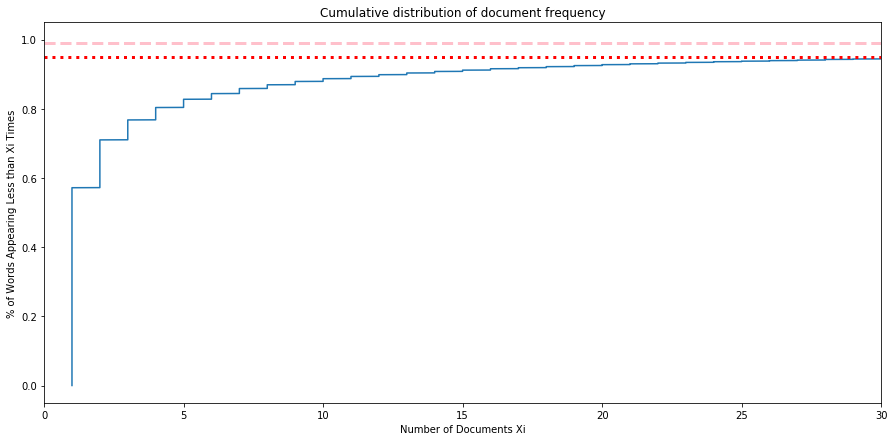

In [43]:
data = np.sum(X>0,axis=0)
sorted_df = np.sort(data).reshape(-1,1)
yvals=np.arange(len(sorted_df))/float(len(sorted_df)-1)
plt.figure(figsize = (15,7))
plt.plot(sorted_df,yvals)
plt.xlim([0,30])
plt.axhline(0.95, c = 'red', linestyle = ':', linewidth = 3)
plt.axhline(0.99, c = 'pink', linestyle = '--', linewidth =3)
plt.xlabel('Number of Documents Xi')
plt.ylabel('% of Words Appearing Less than Xi Times')
plt.title('Cumulative distribution of document frequency')
plt.show()

In [21]:
#Balance train Data 
ros = RandomOverSampler(random_state=77)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
print(sorted(Counter(y_resampled_ros).items()))

[(0, 23522), (1, 23522), (2, 23522), (3, 23522), (4, 23522), (5, 23522)]


In [22]:
#Balance test data
X_resampled_ros_test, y_resampled_ros_test = ros.fit_resample(X_test_vect.values, y_test.values)
print(sorted(Counter(y_resampled_ros_test).items()))

[(0, 5982), (1, 5982), (2, 5982), (3, 5982), (4, 5982), (5, 5982)]


In [26]:
#Random Forest

#Instantiate our model 
rf = RandomForestClassifier(n_estimators = 250, max_depth = 500, max_features = 'log2',
                            n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_resampled_ros_test)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_ros_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_ros_test).sum()/len(y_pred), 3)))

Fit time: 762.964 / Predict time: 10.184 ---- Precision: 0.709 / Recall: 0.67 / Accuracy: 0.67


In [33]:
#Random Forest

#Instantiate our model 
rf = RandomForestClassifier(n_estimators = 250, max_depth = 500, max_features = 'auto',
                            n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_resampled_ros_test)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_ros_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_ros_test).sum()/len(y_pred), 3)))

Fit time: 1516.736 / Predict time: 7.015 ---- Precision: 0.703 / Recall: 0.667 / Accuracy: 0.667


In [34]:
#Random Forest

#Instantiate our model 
rf = RandomForestClassifier(n_estimators = 250, max_depth = 500, max_features = 'sqrt',
                            n_jobs=-1)

#Model Fit 
start = time.time()
rf.fit(X_resampled_ros, y_resampled_ros)
end = time.time()
fit_time = (end - start)

#Model Predict 
start = time.time()
y_pred = rf.predict(X_resampled_ros_test)
end = time.time()
pred_time = (end - start)

#Model Scoring 
precision, recall, fscore, support = precision_recall_fscore_support(y_resampled_ros_test, y_pred, average='macro')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_resampled_ros_test).sum()/len(y_pred), 3)))

Fit time: 1506.123 / Predict time: 6.911 ---- Precision: 0.703 / Recall: 0.666 / Accuracy: 0.666


In [35]:
score = []
index = []

for x in range(10000,11000,100):
    index.append(x)
    count_vecto = CountVectorizer(stop_words = my_stop_words, max_features = x)
    count_vecto_fit = count_vecto.fit(X_train['clean_text'])

    count_train = count_vecto_fit.transform(X_train['clean_text'])
    count_test = count_vecto_fit.transform(X_test['clean_text'])

    X_train_vect = pd.concat([X_train[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                           'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                           'tweet_len','cap_count']].reset_index(drop=True), 
               pd.DataFrame(count_train.toarray())], axis=1)
    X_test_vect = pd.concat([X_test[['hash_count', 'emoji_count', 'anger','anticipation','disgust','fear',
                                                           'joy', 'sadness', 'surprise', 'trust', 'punc_count',
                                                           'tweet_len','cap_count']].reset_index(drop=True), 
               pd.DataFrame(count_test.toarray())], axis=1)
    
    ros = RandomOverSampler(random_state=77)
    X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_vect.values, y_train.values)
    X_resampled_ros_test, y_resampled_ros_test = ros.fit_resample(X_test_vect.values, y_test.values)
    rf = RandomForestClassifier(n_estimators = 250, max_depth = 500, max_features = 'log2',
                            n_jobs=-1)
    rf.fit(X_resampled_ros, y_resampled_ros)
    score.append(round((y_pred==y_resampled_ros_test).sum()/len(y_pred), 3))

In [36]:
rf_line = pd.DataFrame([index,score])
rf_line.to_csv('rf_line.csv')

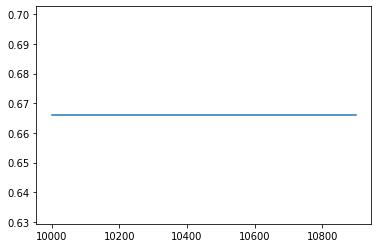

In [37]:
import seaborn as sns
sns.lineplot(index,score)

In [40]:
index

[10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900]

In [41]:
score

[0.666, 0.666, 0.666, 0.666, 0.666, 0.666, 0.666, 0.666, 0.666, 0.666]

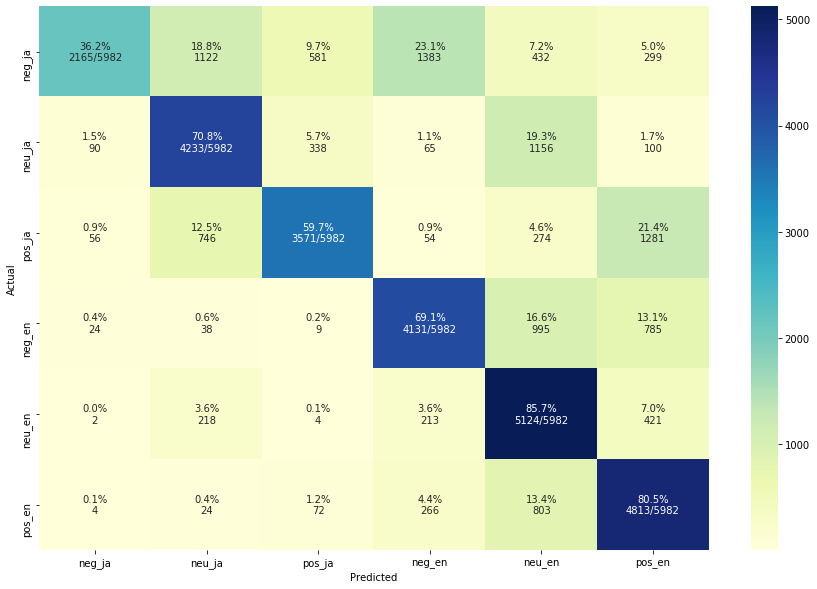

In [27]:
#Confusion matrix 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_resampled_ros_test, y_pred)
class_names = ['neg_ja', 'neu_ja', 'pos_ja', 'neg_en', 'neu_en', 'pos_en']


def plot_cm(y_true, y_pred, figsize=(15,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_cm(y_resampled_ros_test, y_pred)
plt.show()

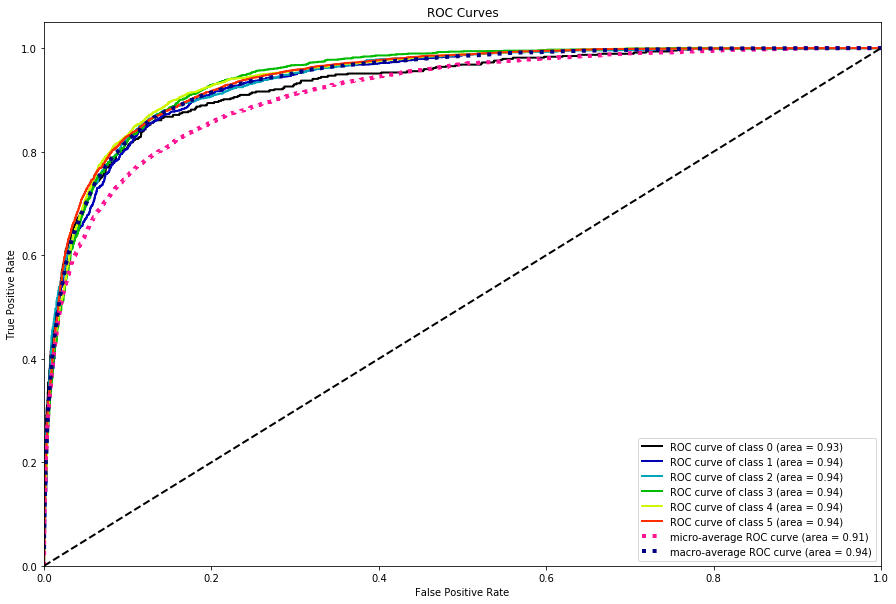

In [31]:
#ROC AUC
import scikitplot as scikitplot #to make things easy
y_pred_proba = rf.predict_proba(X_resampled_ros_test)
scikitplot.metrics.plot_roc(y_resampled_ros_test, y_pred_proba, figsize=(15,10))
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score

y_prob = rf.predict_proba(X_resampled_ros_test)

macro_roc_auc_ovo = roc_auc_score(y_resampled_ros_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_resampled_ros_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_resampled_ros_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_resampled_ros_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.938675 (macro),
0.938675 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.938675 (macro),
0.938675 (weighted by prevalence)
